<a href="https://colab.research.google.com/github/abhijadhav14/Sustainable-AI-Energy-Consumption-Prediction-Model/blob/main/sustainable_energy_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sustainable AI Energy Consumption Prediction Model

This notebook demonstrates a sustainable approach to building an energy consumption prediction model. It includes:

1. Data loading and preprocessing
2. Feature engineering and selection
3. Model training with energy efficiency constraints
4. Evaluation with both performance and sustainability metrics
5. Visualization of results

The model follows sustainable AI principles by:
- Tracking energy consumption during training
- Optimizing for model efficiency
- Providing interpretability
- Balancing performance with resource usage

## Setup and Dependencies

First, let's install the required packages and import necessary libraries.

In [1]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap psutil

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
import xgboost as xgb
import shap
import time
import psutil
import os
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## Energy Consumption Tracking

Let's create a class to track energy consumption during model training and inference.

In [3]:
class EnergyTracker:
    """Tracks energy consumption of AI model training and inference."""

    def __init__(self, device_type='cpu', power_consumption_watts=None):
        """Initialize the energy tracker.

        Args:
            device_type: Type of computing device ('cpu', 'gpu')
            power_consumption_watts: Optional override for device power consumption
        """
        self.device_type = device_type.lower()
        self.start_time = None
        self.end_time = None
        self.duration_seconds = 0
        self.total_energy_kwh = 0

        # Set default power consumption based on device type if not provided
        if power_consumption_watts is None:
            if self.device_type == 'cpu':
                self.power_consumption_watts = 65  # Average CPU power consumption
            elif self.device_type == 'gpu':
                self.power_consumption_watts = 250  # Average GPU power consumption
            else:
                self.power_consumption_watts = 100  # Default for unknown devices
        else:
            self.power_consumption_watts = power_consumption_watts

        # Initialize tracking variables
        self.tracking_history = []
        self.cpu_percent_history = []
        self.memory_percent_history = []

    def start_tracking(self):
        """Start tracking energy consumption."""
        self.start_time = time.time()
        self.cpu_percent_history = []
        self.memory_percent_history = []

    def stop_tracking(self):
        """Stop tracking energy consumption and calculate metrics."""
        if self.start_time is None:
            raise ValueError("Tracking was not started. Call start_tracking() first.")

        self.end_time = time.time()
        self.duration_seconds = self.end_time - self.start_time

        # Calculate energy consumption in kilowatt-hours
        # Power (W) * Time (h) / 1000 = Energy (kWh)
        self.total_energy_kwh = (self.power_consumption_watts * self.duration_seconds / 3600) / 1000

        # Calculate average CPU and memory usage
        avg_cpu_percent = np.mean(self.cpu_percent_history) if self.cpu_percent_history else 0
        avg_memory_percent = np.mean(self.memory_percent_history) if self.memory_percent_history else 0

        # Record tracking session
        session_data = {
            'device_type': self.device_type,
            'power_consumption_watts': self.power_consumption_watts,
            'duration_seconds': self.duration_seconds,
            'energy_consumption_kwh': self.total_energy_kwh,
            'avg_cpu_percent': avg_cpu_percent,
            'avg_memory_percent': avg_memory_percent,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        self.tracking_history.append(session_data)

        return session_data

    def monitor_resources(self):
        """Monitor CPU and memory usage during tracking."""
        if self.start_time is not None:
            self.cpu_percent_history.append(psutil.cpu_percent())
            self.memory_percent_history.append(psutil.virtual_memory().percent)

    def get_carbon_footprint(self, region='global', renewable_percentage=0):
        """Calculate carbon footprint based on energy consumption.

        Args:
            region: Geographic region for carbon intensity calculation
            renewable_percentage: Percentage of energy from renewable sources (0-100)

        Returns:
            Carbon footprint in kg CO2 equivalent
        """
        # Carbon intensity of electricity by region (kg CO2 per kWh)
        carbon_intensity = {
            'global': 0.475,
            'us': 0.417,
            'eu': 0.275,
            'china': 0.555,
            'india': 0.708,
            'canada': 0.135,
            'uk': 0.233,
            'france': 0.056,
            'germany': 0.338
        }

        # Get carbon intensity for the specified region
        intensity = carbon_intensity.get(region.lower(), carbon_intensity['global'])

        # Apply renewable energy percentage
        effective_intensity = intensity * (1 - renewable_percentage / 100)

        # Calculate carbon footprint
        return self.total_energy_kwh * effective_intensity

    def plot_energy_consumption(self):
        """Plot energy consumption history."""
        if not self.tracking_history:
            print("No tracking history available.")
            return

        # Extract data for plotting
        labels = [f"Session {i+1}" for i in range(len(self.tracking_history))]
        energy_values = [session['energy_consumption_kwh'] for session in self.tracking_history]
        durations = [session['duration_seconds'] for session in self.tracking_history]

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot energy consumption
        bars1 = ax1.bar(labels, energy_values, color='skyblue')
        ax1.set_xlabel('Training Session')
        ax1.set_ylabel('Energy Consumption (kWh)')
        ax1.set_title('Energy Consumption by Training Session')

        # Add value labels
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                    f'{height:.6f}',
                    ha='center', va='bottom', rotation=0)

        # Plot duration
        bars2 = ax2.bar(labels, durations, color='lightgreen')
        ax2.set_xlabel('Training Session')
        ax2.set_ylabel('Duration (seconds)')
        ax2.set_title('Training Duration by Session')

        # Add value labels
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.2f}',
                    ha='center', va='bottom', rotation=0)

        plt.tight_layout()
        plt.show()

        # If we have CPU and memory data, plot resource usage
        if self.cpu_percent_history and self.memory_percent_history:
            plt.figure(figsize=(12, 6))
            plt.plot(self.cpu_percent_history, label='CPU Usage (%)', color='blue')
            plt.plot(self.memory_percent_history, label='Memory Usage (%)', color='green')
            plt.xlabel('Monitoring Interval')
            plt.ylabel('Usage Percentage')
            plt.title('Resource Usage During Training')
            plt.legend()
            plt.grid(True)
            plt.show()

## Data Loading and Exploration

Now, let's load the energy consumption dataset and explore its characteristics.

In [4]:
# Upload the CSV file
from google.colab import files
uploaded = files.upload()  # Upload energy_consumption_data.csv

# Load the dataset
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nData types:")
display(df.dtypes)

print("\nSummary statistics:")
display(df.describe())

Saving energy_consumption_data.csv to energy_consumption_data.csv
Dataset shape: (168, 12)

First 5 rows:


,timestamp,temperature,humidity,day_of_week,hour_of_day,is_weekend,is_holiday,occupancy,appliances_in_use,hvac_status,solar_generation,energy_consumption
0,2025-01-01 00:00:00,18.2,45,2,0,0,1,2,3,1,0.0,2.45
1,2025-01-01 01:00:00,17.8,46,2,1,0,1,2,2,1,0.0,2.31
2,2025-01-01 02:00:00,17.5,47,2,2,0,1,2,1,1,0.0,2.12
3,2025-01-01 03:00:00,17.1,48,2,3,0,1,2,1,1,0.0,2.05
4,2025-01-01 04:00:00,16.8,49,2,4,0,1,2,1,1,0.0,2.01



Data types:


,0
timestamp,object
temperature,float64
humidity,int64
day_of_week,int64
hour_of_day,int64
is_weekend,int64
is_holiday,int64
occupancy,int64
appliances_in_use,int64
hvac_status,int64



Summary statistics:


,temperature,humidity,day_of_week,hour_of_day,is_weekend,is_holiday,occupancy,appliances_in_use,hvac_status,solar_generation,energy_consumption
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.0,168.000000,168.000000
mean,19.349405,46.446429,3.000000,11.500000,0.285714,0.142857,3.714286,4.880952,1.0,0.266667,3.453155
std,2.263879,6.064285,2.005979,6.942881,0.453104,0.350973,1.497074,2.507019,0.0,0.351841,0.891059
min,15.500000,34.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.0,0.000000,2.010000
25%,17.400000,41.750000,1.000000,5.750000,0.000000,0.000000,2.000000,3.000000,1.0,0.000000,2.650000
50%,19.050000,47.000000,3.000000,11.500000,0.000000,0.000000,4.000000,5.000000,1.0,0.000000,3.430000
75%,21.500000,51.000000,5.000000,17.250000,1.000000,0.000000,5.000000,7.000000,1.0,0.525000,4.120000
max,23.500000,58.000000,6.000000,23.000000,1.000000,1.000000,7.000000,10.000000,1.0,1.000000,5.450000


### Data Preprocessing

Let's preprocess the data by handling timestamps, missing values, and creating additional features.

In [5]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Check for missing values
print("Missing values:")
display(df.isnull().sum())

# Create additional time-based features
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['is_morning'] = (df['hour'] >= 6) & (df['hour'] < 12)
df['is_afternoon'] = (df['hour'] >= 12) & (df['hour'] < 18)
df['is_evening'] = (df['hour'] >= 18) & (df['hour'] < 22)
df['is_night'] = (df['hour'] >= 22) | (df['hour'] < 6)

# Create interaction features
df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
df['occupancy_appliances_interaction'] = df['occupancy'] * df['appliances_in_use']

# Display the updated dataframe
print("\nUpdated dataframe with new features:")
display(df.head())

Missing values:


,0
timestamp,0
temperature,0
humidity,0
day_of_week,0
hour_of_day,0
is_weekend,0
is_holiday,0
occupancy,0
appliances_in_use,0
hvac_status,0



Updated dataframe with new features:


,timestamp,temperature,humidity,day_of_week,hour_of_day,is_weekend,is_holiday,occupancy,appliances_in_use,hvac_status,...,energy_consumption,month,day,hour,is_morning,is_afternoon,is_evening,is_night,temp_humidity_interaction,occupancy_appliances_interaction
0,2025-01-01 00:00:00,18.2,45,2,0,0,1,2,3,1,...,2.45,1,1,0,False,False,False,True,819.0,6
1,2025-01-01 01:00:00,17.8,46,2,1,0,1,2,2,1,...,2.31,1,1,1,False,False,False,True,818.8,4
2,2025-01-01 02:00:00,17.5,47,2,2,0,1,2,1,1,...,2.12,1,1,2,False,False,False,True,822.5,2
3,2025-01-01 03:00:00,17.1,48,2,3,0,1,2,1,1,...,2.05,1,1,3,False,False,False,True,820.8,2
4,2025-01-01 04:00:00,16.8,49,2,4,0,1,2,1,1,...,2.01,1,1,4,False,False,False,True,823.2,2


### Data Visualization

Let's visualize the data to better understand the patterns and relationships.

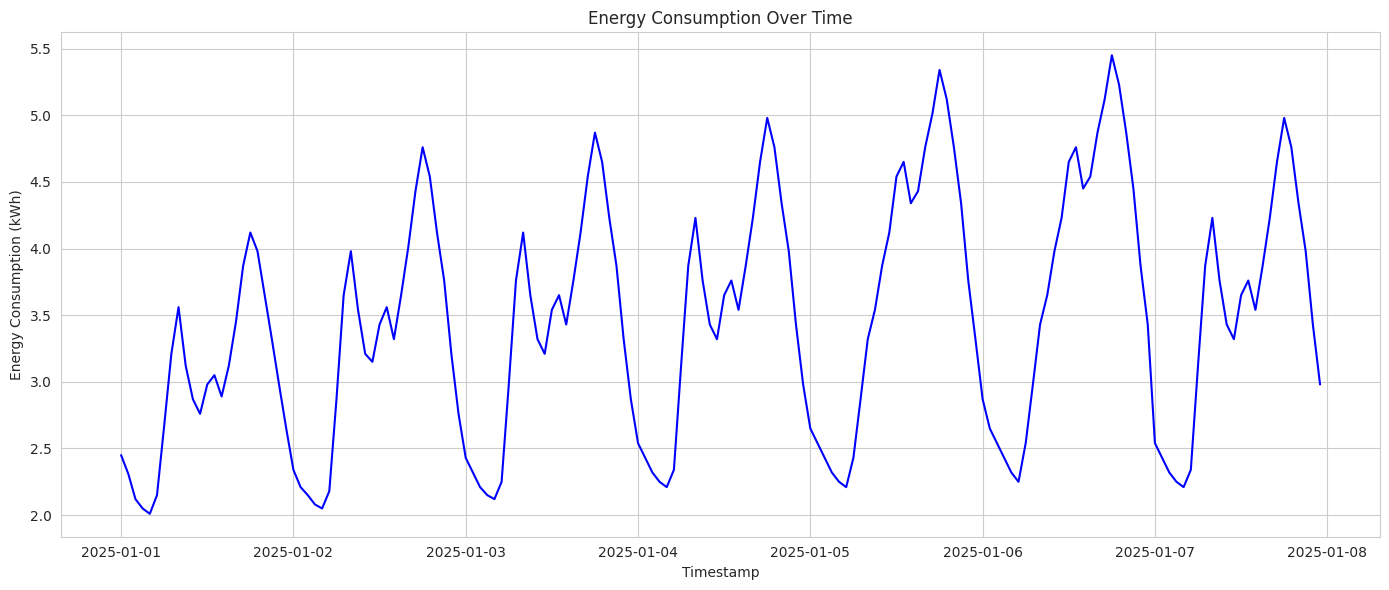

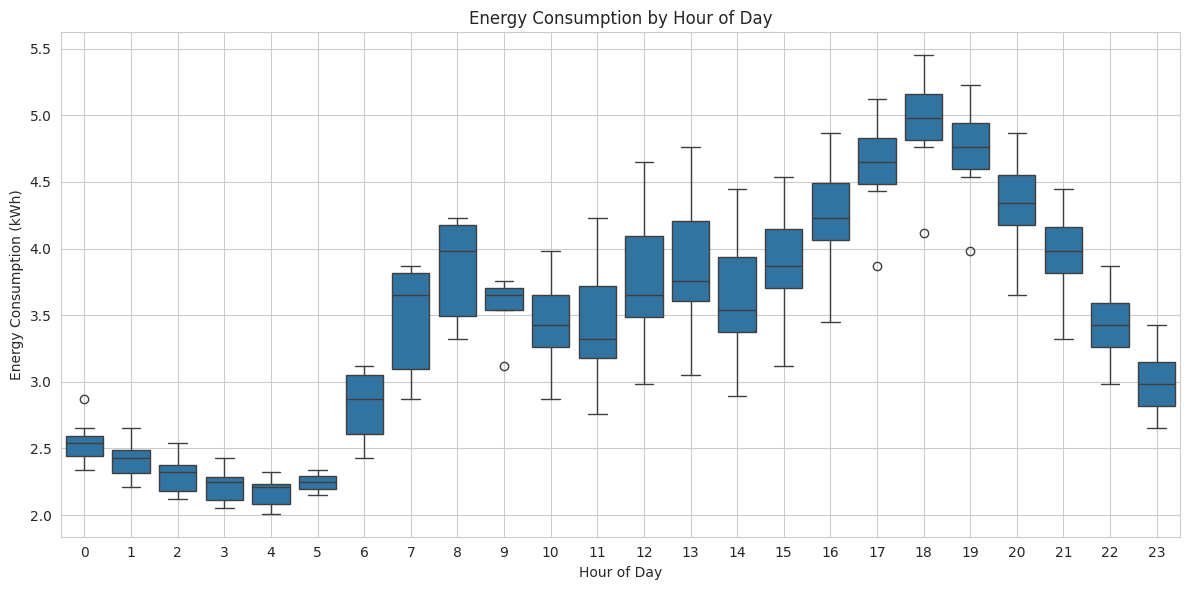

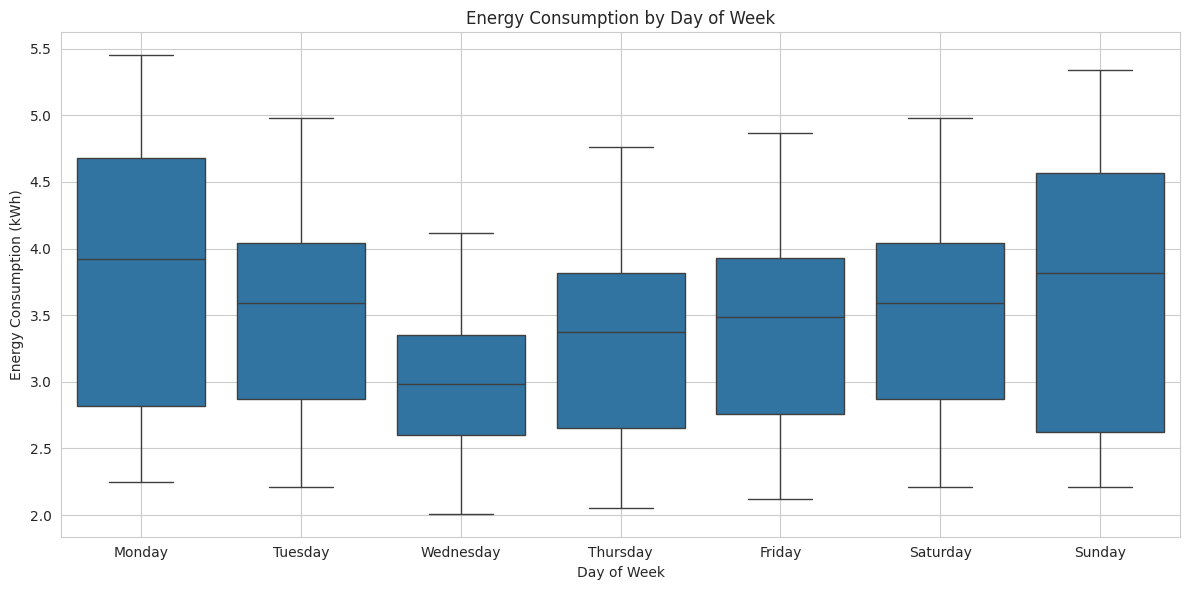

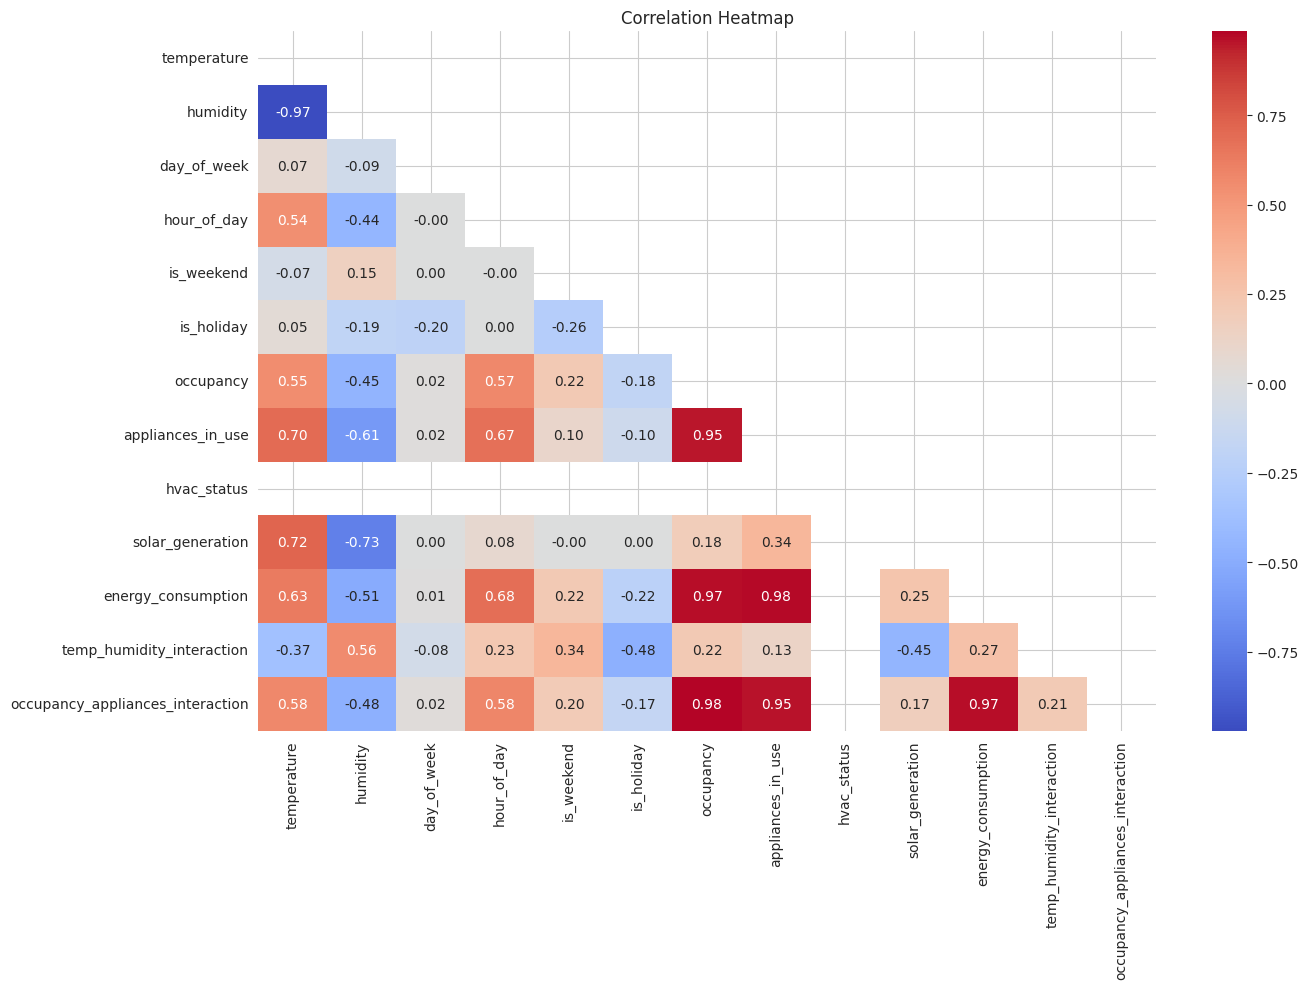

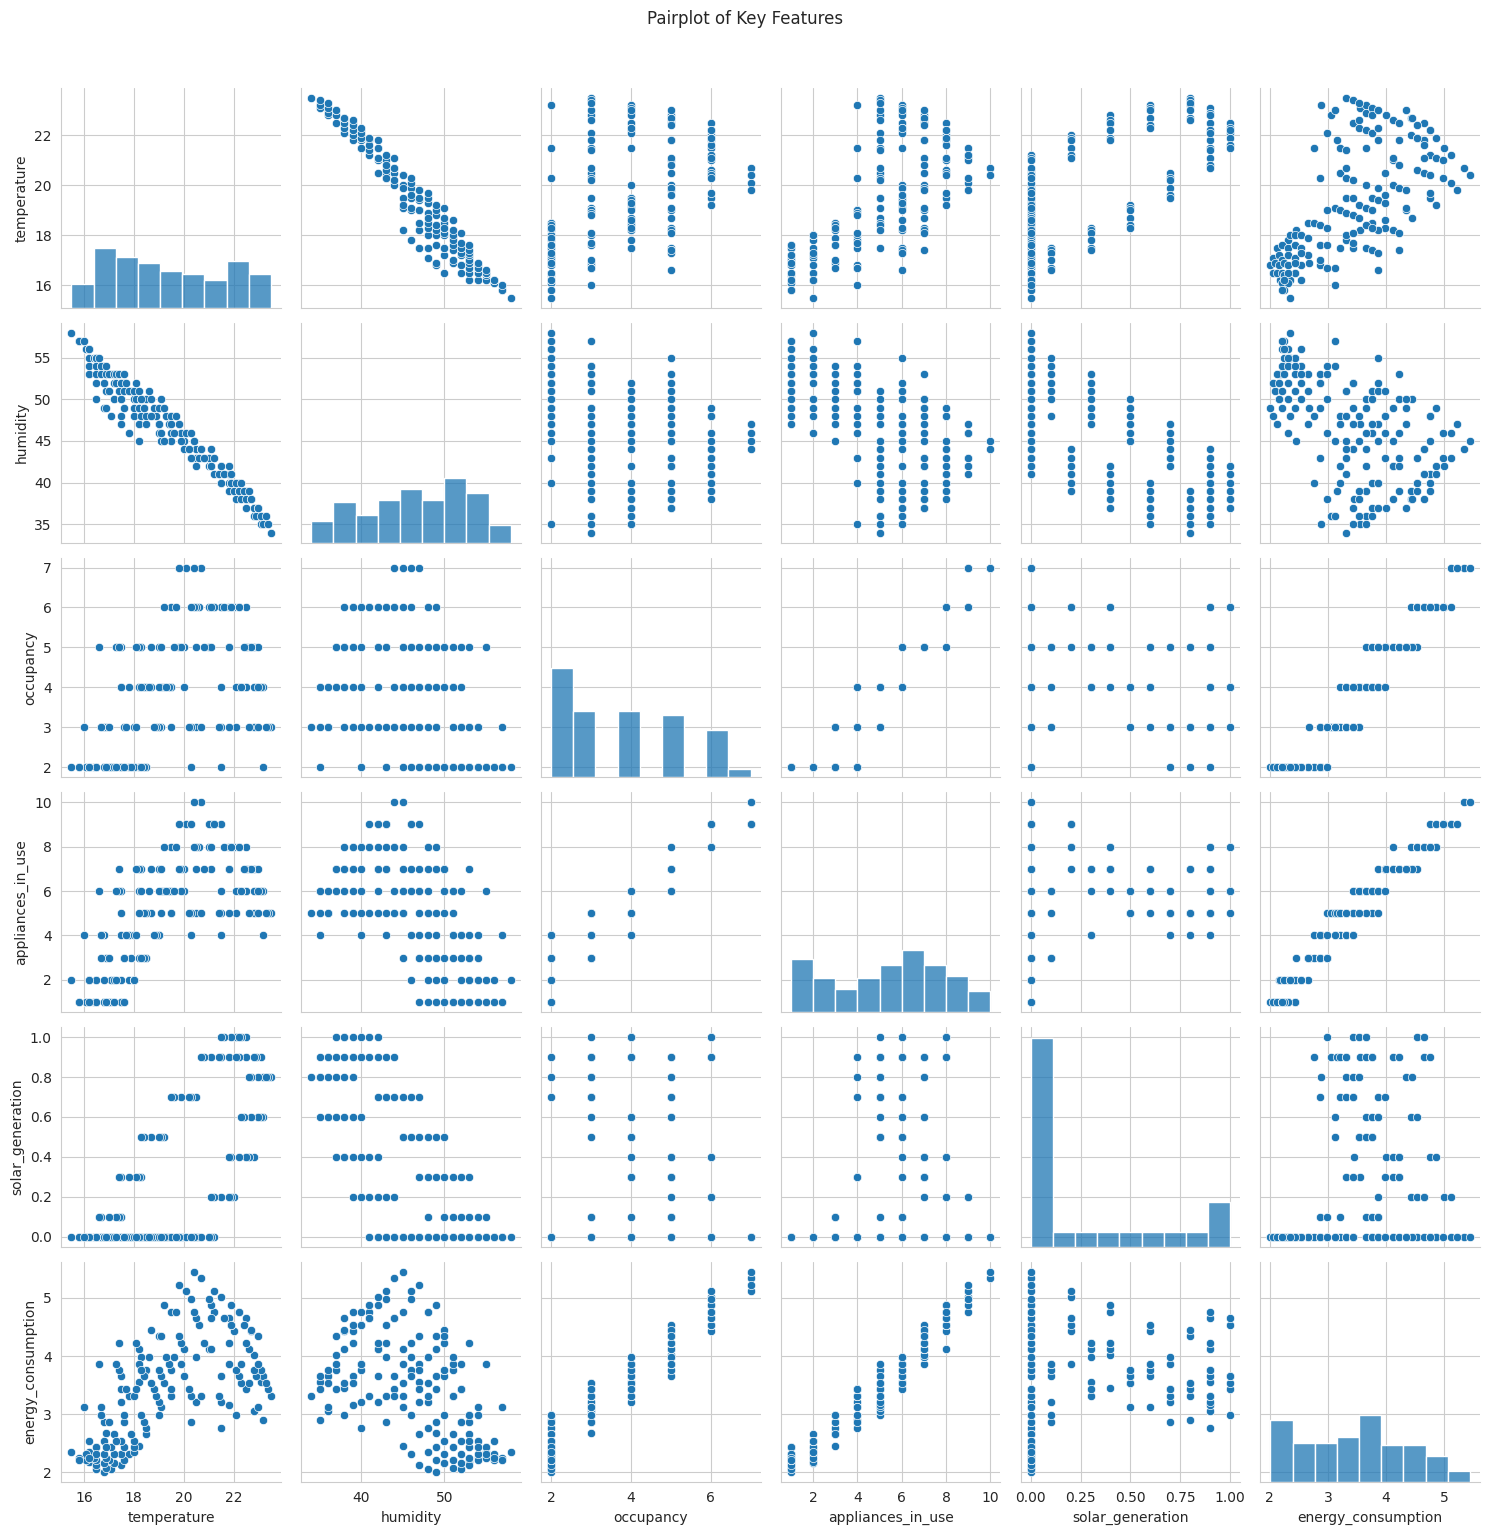

In [6]:
# Plot energy consumption over time
plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['energy_consumption'], color='blue')
plt.title('Energy Consumption Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot energy consumption by hour of day
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour_of_day', y='energy_consumption', data=df)
plt.title('Energy Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot energy consumption by day of week
plt.figure(figsize=(12, 6))
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='day_of_week', y='energy_consumption', data=df)
plt.xticks(range(7), day_names)
plt.title('Energy Consumption by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Energy Consumption (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation = numeric_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Plot pairplot for key features
key_features = ['temperature', 'humidity', 'occupancy', 'appliances_in_use', 'solar_generation', 'energy_consumption']
sns.pairplot(df[key_features], height=2.5)
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.tight_layout()
plt.show()

## Feature Selection and Data Preparation

Let's select the relevant features and prepare the data for modeling.

In [7]:
# Select features for modeling
features = [
    'temperature', 'humidity', 'day_of_week', 'hour_of_day', 'is_weekend', 'is_holiday',
    'occupancy', 'appliances_in_use', 'hvac_status', 'solar_generation',
    'is_morning', 'is_afternoon', 'is_evening', 'is_night',
    'temp_humidity_interaction', 'occupancy_appliances_interaction'
]

# Define target variable
target = 'energy_consumption'

# Prepare X and y
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (134, 16)
Testing set shape: (34, 16)


## Model Training with Energy Tracking

Now, let's train different models while tracking their energy consumption.

In [8]:
# Initialize energy tracker
energy_tracker = EnergyTracker(device_type='cpu')

# Function to train and evaluate a model with energy tracking
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, energy_tracker):
    print(f"\n{'-'*50}")
    print(f"Training {model_name}...")

    # Start energy tracking
    energy_tracker.start_tracking()

    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Stop energy tracking
    energy_metrics = energy_tracker.stop_tracking()

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Calculate carbon footprint
    carbon_footprint = energy_tracker.get_carbon_footprint(region='global', renewable_percentage=20)

    # Print results
    print(f"\nPerformance Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    print(f"\nSustainability Metrics:")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Energy Consumption: {energy_metrics['energy_consumption_kwh']:.6f} kWh")
    print(f"Carbon Footprint: {carbon_footprint:.6f} kg CO2eq")

    # Calculate model size (approximate)
    import sys
    model_size_bytes = sys.getsizeof(model)
    print(f"Model Size: {model_size_bytes / 1024:.2f} KB")

    # Return metrics
    return {
        'model': model,
        'model_name': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'training_time': training_time,
        'energy_consumption': energy_metrics['energy_consumption_kwh'],
        'carbon_footprint': carbon_footprint,
        'model_size': model_size_bytes / 1024
    }

# Train different models
models = [
    (LinearRegression(), "Linear Regression"),
    (Ridge(alpha=1.0), "Ridge Regression"),
    (RandomForestRegressor(n_estimators=100, random_state=42), "Random Forest"),
    (GradientBoostingRegressor(n_estimators=100, random_state=42), "Gradient Boosting"),
    (xgb.XGBRegressor(n_estimators=100, random_state=42), "XGBoost")
]

# Train and evaluate each model
results = []
for model, model_name in models:
    result = train_and_evaluate_model(model, model_name, X_train_scaled, y_train, X_test_scaled, y_test, energy_tracker)
    results.append(result)


--------------------------------------------------
Training Linear Regression...

Performance Metrics:
RMSE: 0.1128
MAE: 0.0926
R²: 0.9825

Sustainability Metrics:
Training Time: 0.0125 seconds
Energy Consumption: 0.000000 kWh
Carbon Footprint: 0.000000 kg CO2eq
Model Size: 0.05 KB

--------------------------------------------------
Training Ridge Regression...

Performance Metrics:
RMSE: 0.1108
MAE: 0.0927
R²: 0.9832

Sustainability Metrics:
Training Time: 0.0029 seconds
Energy Consumption: 0.000000 kWh
Carbon Footprint: 0.000000 kg CO2eq
Model Size: 0.05 KB

--------------------------------------------------
Training Random Forest...

Performance Metrics:
RMSE: 0.1043
MAE: 0.0846
R²: 0.9851

Sustainability Metrics:
Training Time: 0.1712 seconds
Energy Consumption: 0.000003 kWh
Carbon Footprint: 0.000001 kg CO2eq
Model Size: 0.05 KB

--------------------------------------------------
Training Gradient Boosting...

Performance Metrics:
RMSE: 0.0711
MAE: 0.0577
R²: 0.9931

Sustainabili

## Model Comparison and Visualization

Let's compare the models based on both performance and sustainability metrics.

Model Comparison:


,Model,RMSE,MAE,R²,Training Time (s),Energy (kWh),Carbon (kg CO2),Model Size (KB)
0,Linear Regression,0.112846,0.092643,0.982545,0.012487,2.256307e-07,8.573968e-08,0.054688
1,Ridge Regression,0.110790,0.092661,0.983175,0.002929,5.370643e-08,2.040844e-08,0.054688
2,Random Forest,0.104290,0.084606,0.985091,0.171245,3.092055e-06,1.174981e-06,0.054688
3,Gradient Boosting,0.071054,0.057704,0.993080,0.114945,2.075537e-06,7.887040e-07,0.054688
4,XGBoost,0.091517,0.075782,0.988520,0.092937,1.678167e-06,6.377034e-07,0.054688


<ipython-input-9-48526d9a182d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results_df, palette='Blues_d')
<ipython-input-9-48526d9a182d>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results_df, palette='Blues_d')
<ipython-input-9-48526d9a182d>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R²', data=results_df, palette='Blues_d')


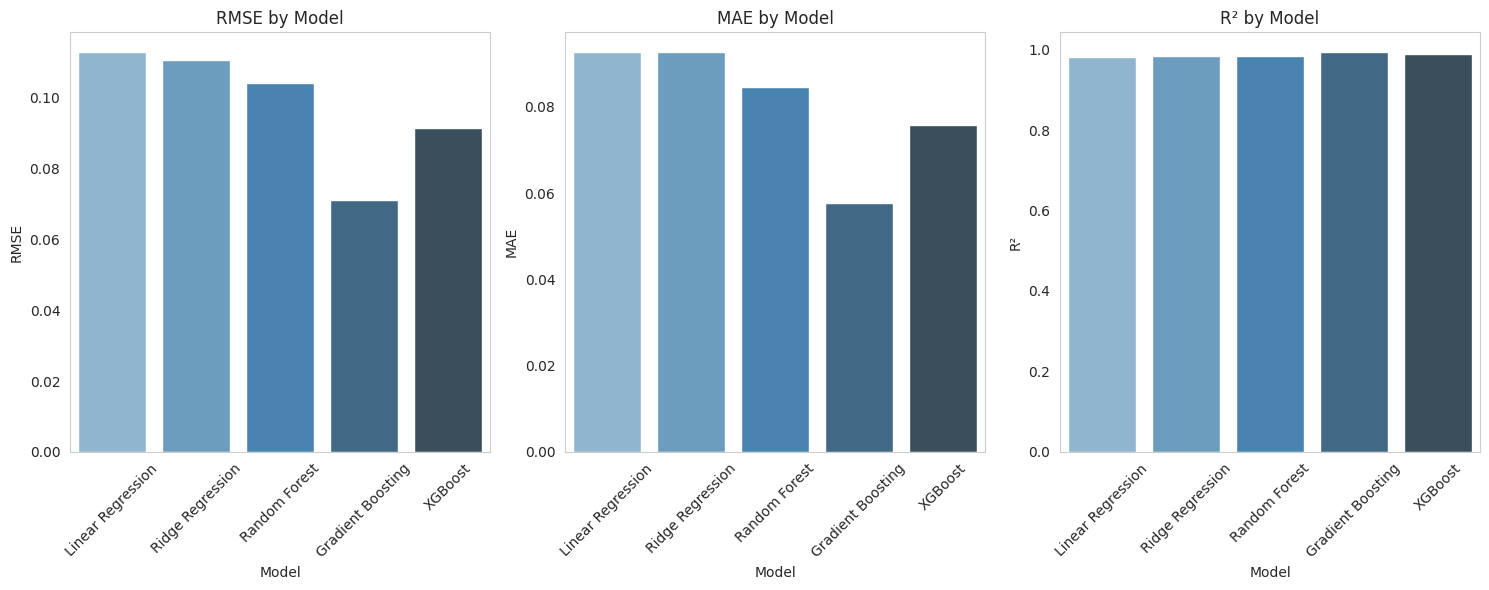

<ipython-input-9-48526d9a182d>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Training Time (s)', data=results_df, palette='Greens_d')
<ipython-input-9-48526d9a182d>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Energy (kWh)', data=results_df, palette='Greens_d')
<ipython-input-9-48526d9a182d>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Carbon (kg CO2)', data=results_df, palette='Greens_d')


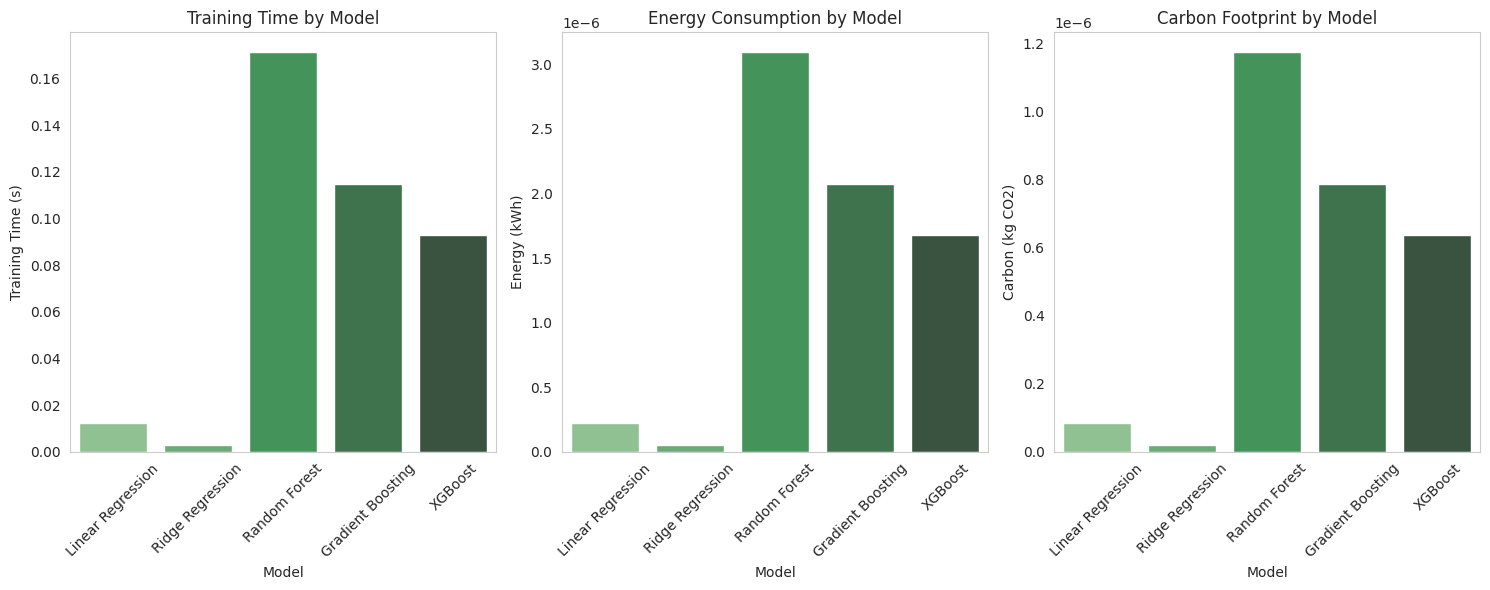

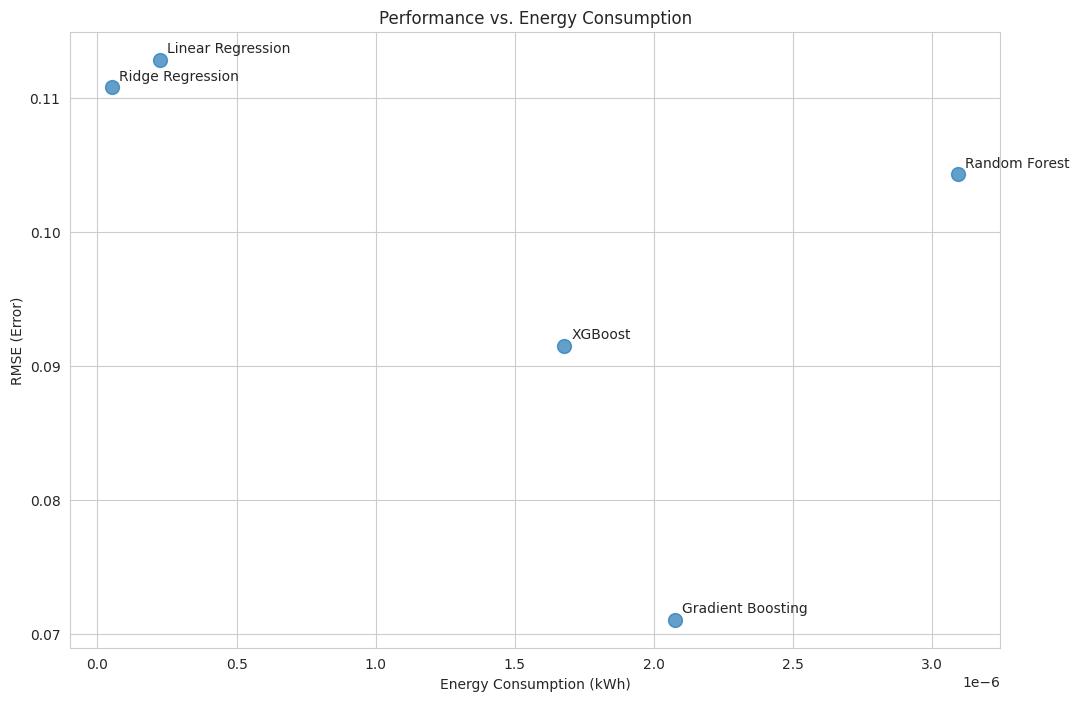

In [9]:
# Create a dataframe with results
results_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'RMSE': r['rmse'],
        'MAE': r['mae'],
        'R²': r['r2'],
        'Training Time (s)': r['training_time'],
        'Energy (kWh)': r['energy_consumption'],
        'Carbon (kg CO2)': r['carbon_footprint'],
        'Model Size (KB)': r['model_size']
    } for r in results
])

# Display results table
print("Model Comparison:")
display(results_df)

# Plot performance metrics
plt.figure(figsize=(15, 6))

# RMSE
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='RMSE', data=results_df, palette='Blues_d')
plt.title('RMSE by Model')
plt.xticks(rotation=45)
plt.grid(axis='y')

# MAE
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='MAE', data=results_df, palette='Blues_d')
plt.title('MAE by Model')
plt.xticks(rotation=45)
plt.grid(axis='y')

# R²
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='R²', data=results_df, palette='Blues_d')
plt.title('R² by Model')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Plot sustainability metrics
plt.figure(figsize=(15, 6))

# Training Time
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='Training Time (s)', data=results_df, palette='Greens_d')
plt.title('Training Time by Model')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Energy Consumption
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='Energy (kWh)', data=results_df, palette='Greens_d')
plt.title('Energy Consumption by Model')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Carbon Footprint
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='Carbon (kg CO2)', data=results_df, palette='Greens_d')
plt.title('Carbon Footprint by Model')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Plot performance vs. sustainability
plt.figure(figsize=(12, 8))
plt.scatter(results_df['Energy (kWh)'], results_df['RMSE'], s=100, alpha=0.7)

# Add model names as labels
for i, model in enumerate(results_df['Model']):
    plt.annotate(model,
                 (results_df['Energy (kWh)'].iloc[i], results_df['RMSE'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')

plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('RMSE (Error)')
plt.title('Performance vs. Energy Consumption')
plt.grid(True)
plt.show()

## Model Interpretability with SHAP

Let's use SHAP values to interpret the best performing model.

Best model based on R²: Gradient Boosting


<ipython-input-10-87a3cfe54f92>:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=features)


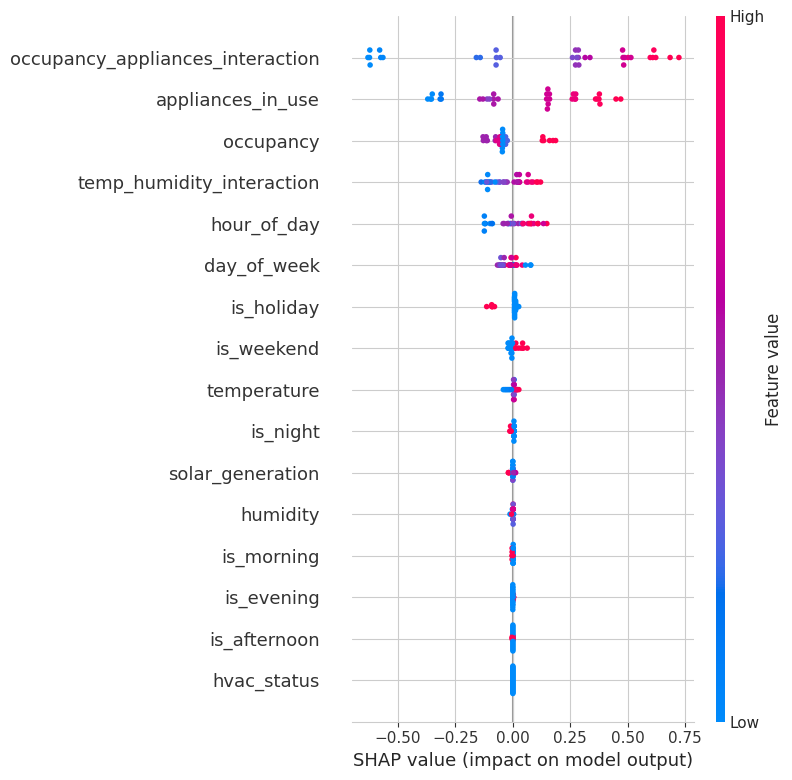

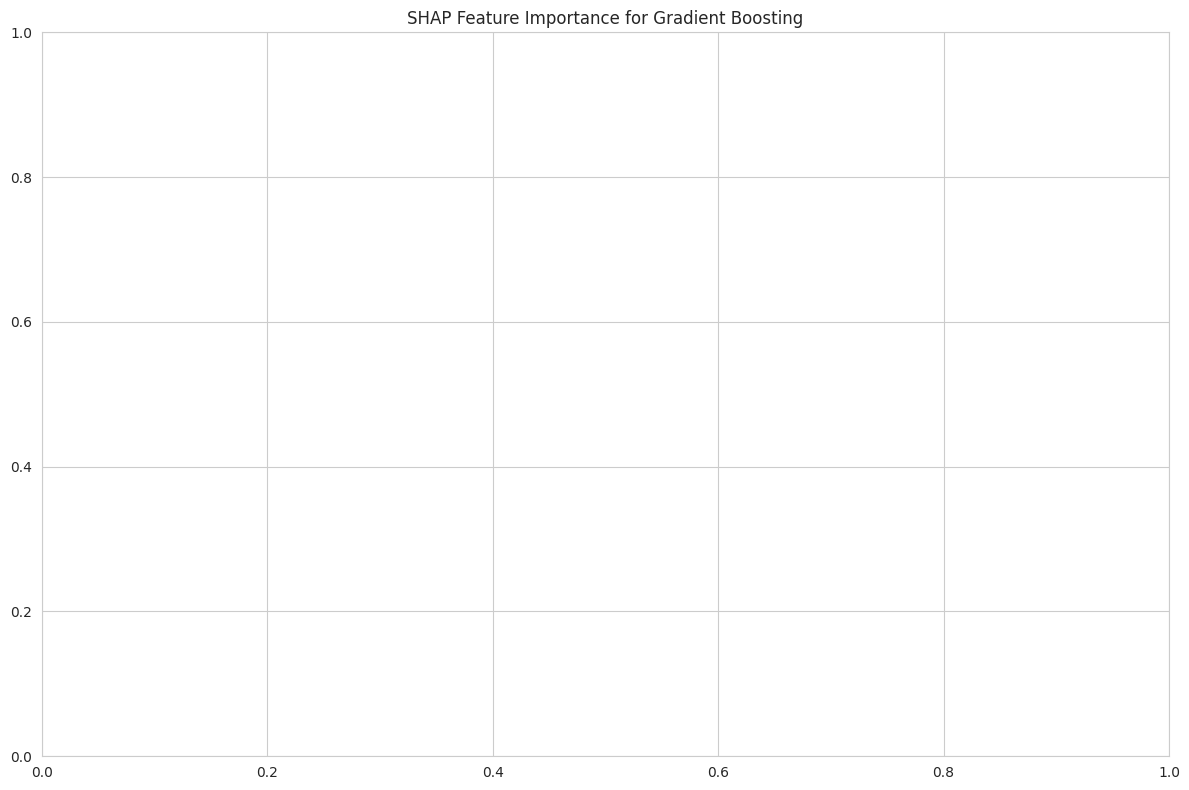

<Figure size 1000x600 with 0 Axes>

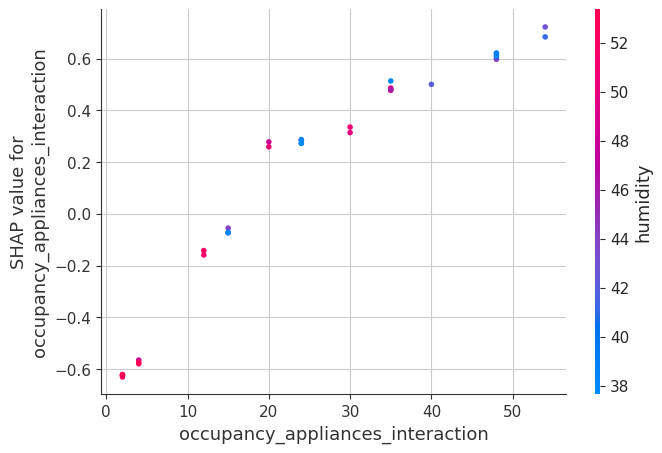

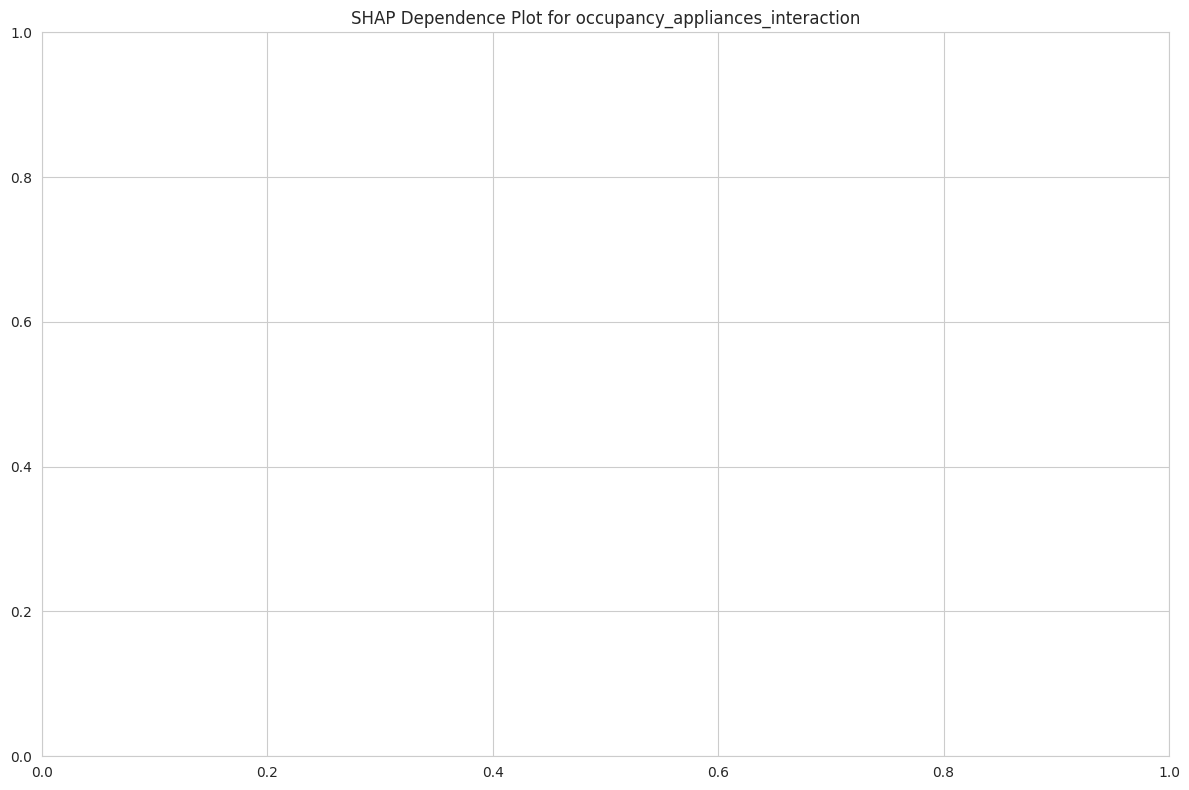

<Figure size 1000x600 with 0 Axes>

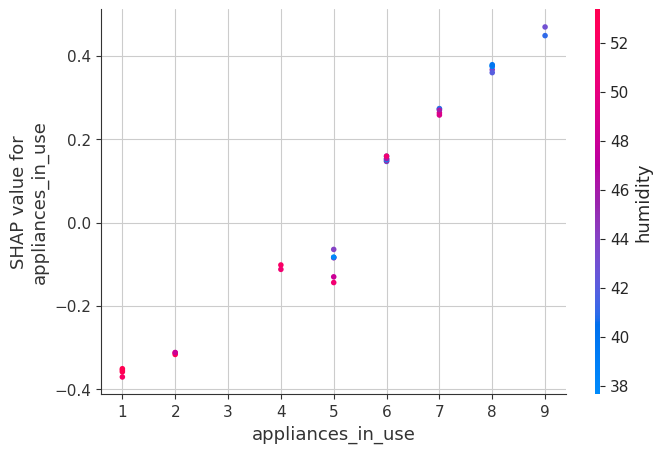

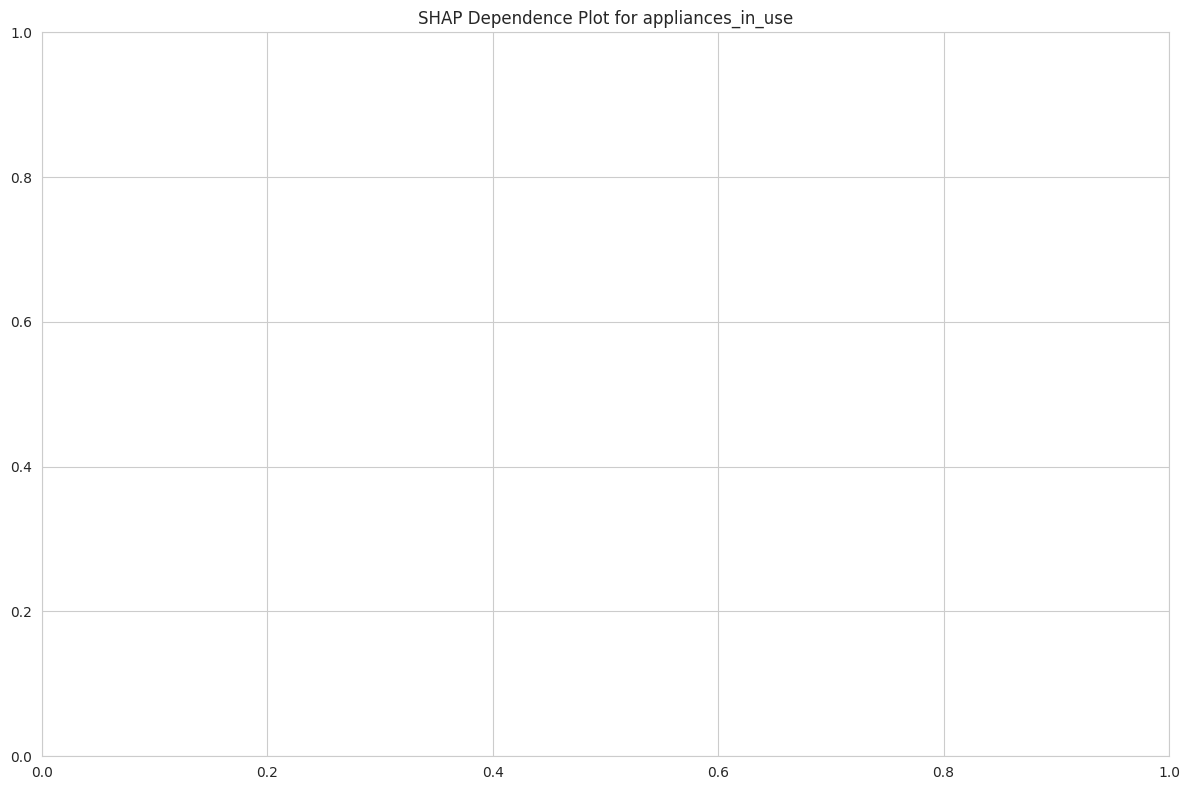

<Figure size 1000x600 with 0 Axes>

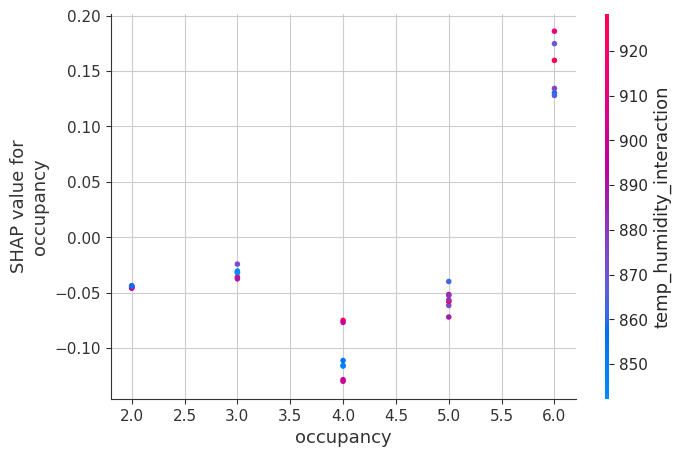

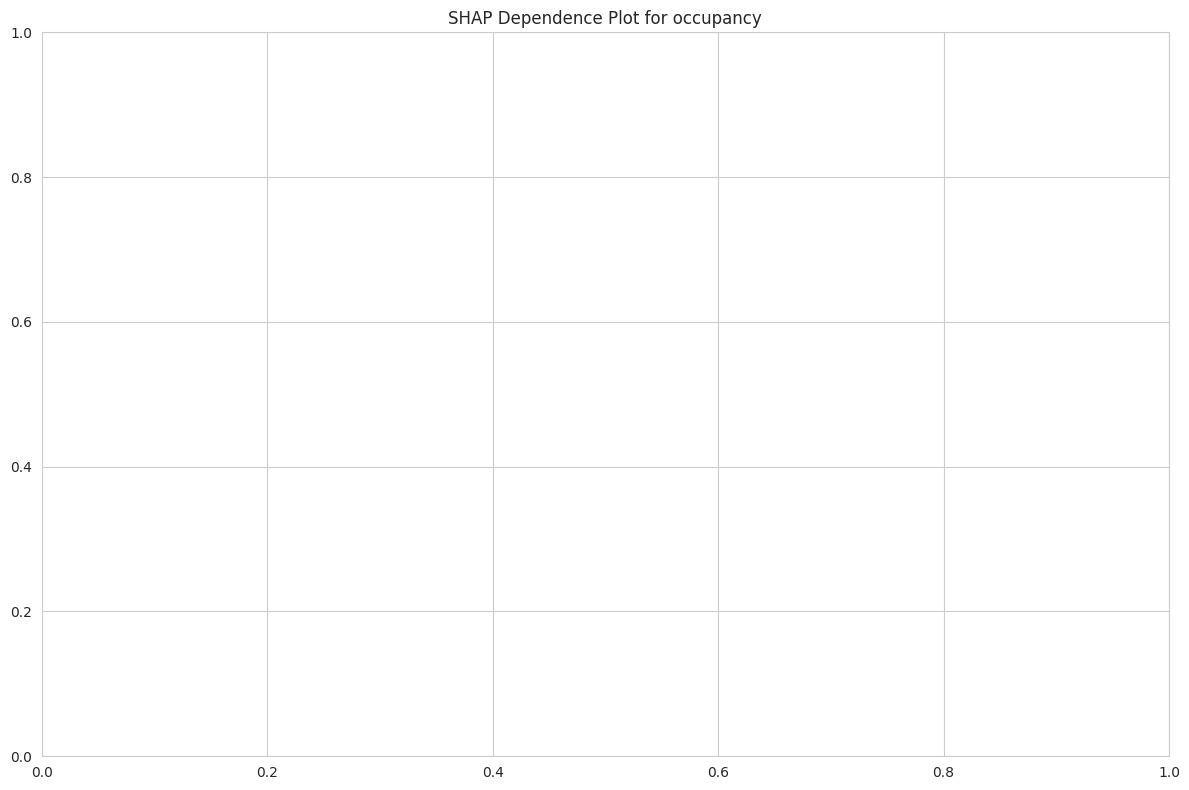

In [10]:
# Find the best model based on R²
best_model_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model = results[best_model_idx]['model']

print(f"Best model based on R²: {best_model_name}")

# Create SHAP explainer
if best_model_name in ["Random Forest", "Gradient Boosting", "XGBoost"]:
    explainer = shap.TreeExplainer(best_model)
else:
    explainer = shap.LinearExplainer(best_model, X_train_scaled)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=features)
plt.title(f"SHAP Feature Importance for {best_model_name}")
plt.tight_layout()
plt.show()

# Plot SHAP dependence plots for top features
# Get feature importance
feature_importance = np.abs(shap_values).mean(0)
feature_importance_df = pd.DataFrame(list(zip(features, feature_importance)), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot dependence plots for top 3 features
top_features = feature_importance_df['Feature'].head(3).tolist()
for feature in top_features:
    plt.figure(figsize=(10, 6))
    feature_idx = features.index(feature)
    shap.dependence_plot(feature_idx, shap_values, X_test, feature_names=features)
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()

## Sustainable Model Optimization

Let's optimize the best model for better sustainability while maintaining performance.

Model Comparison with Sustainability Scores:


,Model,RMSE,MAE,R²,Training Time (s),Energy (kWh),Carbon (kg CO2),Model Size (KB),Sustainability Score,Combined Score
3,Gradient Boosting,0.071054,0.057704,0.993080,0.114945,2.075537e-06,7.887040e-07,0.054688,99.778775,99.449204
4,XGBoost,0.091517,0.075782,0.988520,0.092937,1.678167e-06,6.377034e-07,0.054688,99.820692,99.142585
2,Random Forest,0.104290,0.084606,0.985091,0.171245,3.092055e-06,1.174981e-06,0.054688,99.672035,98.858009
1,Ridge Regression,0.110790,0.092661,0.983175,0.002929,5.370643e-08,2.040844e-08,0.054688,99.993218,98.820235
0,Linear Regression,0.112846,0.092643,0.982545,0.012487,2.256307e-07,8.573968e-08,0.054688,99.974839,98.770594


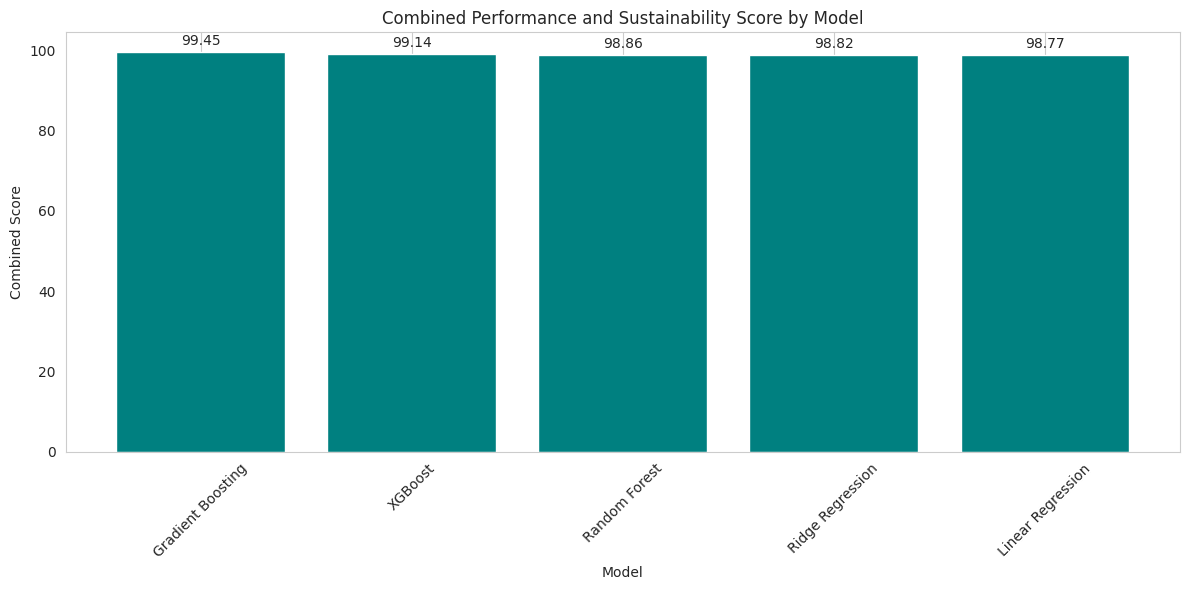

In [11]:
# Function to calculate sustainability score
def calculate_sustainability_score(energy, carbon, model_size, training_time):
    # Normalize values (lower is better)
    energy_norm = 1 / (1 + energy * 1000)  # Scale up for better differentiation
    carbon_norm = 1 / (1 + carbon * 1000)  # Scale up for better differentiation
    size_norm = 1 / (1 + model_size / 1000)  # Convert to MB for scaling
    time_norm = 1 / (1 + training_time / 10)  # Scale for better differentiation

    # Calculate weighted score (higher is better)
    score = 0.4 * energy_norm + 0.3 * carbon_norm + 0.2 * size_norm + 0.1 * time_norm
    return score * 100  # Scale to 0-100

# Add sustainability score to results
results_df['Sustainability Score'] = results_df.apply(
    lambda row: calculate_sustainability_score(
        row['Energy (kWh)'],
        row['Carbon (kg CO2)'],
        row['Model Size (KB)'],
        row['Training Time (s)']
    ),
    axis=1
)

# Calculate combined score (performance + sustainability)
results_df['Combined Score'] = results_df.apply(
    lambda row: 0.7 * row['R²'] * 100 + 0.3 * row['Sustainability Score'],
    axis=1
)

# Display updated results
print("Model Comparison with Sustainability Scores:")
display(results_df.sort_values('Combined Score', ascending=False))

# Plot combined scores
plt.figure(figsize=(12, 6))
results_sorted = results_df.sort_values('Combined Score', ascending=False)
bars = plt.bar(results_sorted['Model'], results_sorted['Combined Score'], color='teal')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.2f}',
            ha='center', va='bottom', rotation=0)

plt.title('Combined Performance and Sustainability Score by Model')
plt.xlabel('Model')
plt.ylabel('Combined Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Optimize the Most Sustainable Model

Let's optimize the model with the best combined score for even better sustainability.

In [12]:
# Find the model with the best combined score
best_combined_idx = results_df['Combined Score'].idxmax()
best_combined_model_name = results_df.loc[best_combined_idx, 'Model']
print(f"Model with best combined score: {best_combined_model_name}")

# Define optimization parameters based on the best model
if best_combined_model_name == "Linear Regression" or best_combined_model_name == "Ridge Regression":
    # For linear models, we can't do much optimization for sustainability
    print("Linear models are already quite sustainable. No further optimization needed.")
    optimized_model = results[best_combined_idx]['model']

elif best_combined_model_name == "Random Forest":
    print("Optimizing Random Forest for sustainability...")

    # Start energy tracking
    energy_tracker.start_tracking()

    # Define parameter grid focusing on sustainability
    param_grid = {
        'n_estimators': [50, 100],  # Fewer trees for efficiency
        'max_depth': [10, 15, None],  # Control model complexity
        'min_samples_split': [2, 5, 10],  # Prevent overfitting
        'min_samples_leaf': [1, 2, 4]  # Prevent overfitting
    }

    # Create base model
    rf = RandomForestRegressor(random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)

    # Get best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    # Create optimized model
    optimized_model = RandomForestRegressor(random_state=42, **best_params)
    optimized_model.fit(X_train_scaled, y_train)

    # Stop energy tracking
    energy_metrics = energy_tracker.stop_tracking()

elif best_combined_model_name == "Gradient Boosting":
    print("Optimizing Gradient Boosting for sustainability...")

    # Start energy tracking
    energy_tracker.start_tracking()

    # Define parameter grid focusing on sustainability
    param_grid = {
        'n_estimators': [50, 100],  # Fewer trees for efficiency
        'max_depth': [3, 5, 7],  # Shallower trees for efficiency
        'learning_rate': [0.05, 0.1, 0.2],  # Control convergence speed
        'subsample': [0.8, 1.0]  # Use subsampling for efficiency
    }

    # Create base model
    gb = GradientBoostingRegressor(random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(gb, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)

    # Get best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    # Create optimized model
    optimized_model = GradientBoostingRegressor(random_state=42, **best_params)
    optimized_model.fit(X_train_scaled, y_train)

    # Stop energy tracking
    energy_metrics = energy_tracker.stop_tracking()

elif best_combined_model_name == "XGBoost":
    print("Optimizing XGBoost for sustainability...")

    # Start energy tracking
    energy_tracker.start_tracking()

    # Define parameter grid focusing on sustainability
    param_grid = {
        'n_estimators': [50, 100],  # Fewer trees for efficiency
        'max_depth': [3, 5, 7],  # Shallower trees for efficiency
        'learning_rate': [0.05, 0.1, 0.2],  # Control convergence speed
        'subsample': [0.8, 1.0],  # Use subsampling for efficiency
        'colsample_bytree': [0.8, 1.0]  # Use feature subsampling for efficiency
    }

    # Create base model
    xgb_model = xgb.XGBRegressor(random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)

    # Get best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    # Create optimized model
    optimized_model = xgb.XGBRegressor(random_state=42, **best_params)
    optimized_model.fit(X_train_scaled, y_train)

    # Stop energy tracking
    energy_metrics = energy_tracker.stop_tracking()

# Evaluate optimized model
if best_combined_model_name not in ["Linear Regression", "Ridge Regression"]:
    # Make predictions
    y_pred = optimized_model.predict(X_test_scaled)

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Calculate carbon footprint
    carbon_footprint = energy_tracker.get_carbon_footprint(region='global', renewable_percentage=20)

    # Calculate model size
    import sys
    model_size_bytes = sys.getsizeof(optimized_model)

    # Print results
    print(f"\nOptimized Model Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    print(f"\nOptimized Model Sustainability:")
    print(f"Training Time: {energy_metrics['duration_seconds']:.4f} seconds")
    print(f"Energy Consumption: {energy_metrics['energy_consumption_kwh']:.6f} kWh")
    print(f"Carbon Footprint: {carbon_footprint:.6f} kg CO2eq")
    print(f"Model Size: {model_size_bytes / 1024:.2f} KB")

    # Calculate sustainability score
    sustainability_score = calculate_sustainability_score(
        energy_metrics['energy_consumption_kwh'],
        carbon_footprint,
        model_size_bytes / 1024,
        energy_metrics['duration_seconds']
    )

    # Calculate combined score
    combined_score = 0.7 * r2 * 100 + 0.3 * sustainability_score

    print(f"\nSustainability Score: {sustainability_score:.2f}")
    print(f"Combined Score: {combined_score:.2f}")

    # Compare with original model
    original_combined_score = results_df.loc[best_combined_idx, 'Combined Score']
    improvement = combined_score - original_combined_score

    print(f"\nImprovement over original model: {improvement:.2f} points ({improvement/original_combined_score*100:.2f}%)")

Model with best combined score: Gradient Boosting
Optimizing Gradient Boosting for sustainability...
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Optimized Model Performance:
RMSE: 0.0644
MAE: 0.0512
R²: 0.9943

Optimized Model Sustainability:
Training Time: 14.0029 seconds
Energy Consumption: 0.000253 kWh
Carbon Footprint: 0.000096 kg CO2eq
Model Size: 0.05 KB

Sustainability Score: 83.46
Combined Score: 94.64

Improvement over original model: -4.81 points (-4.84%)


## Final Model Evaluation and Visualization

Let's evaluate the final optimized model and visualize its predictions.

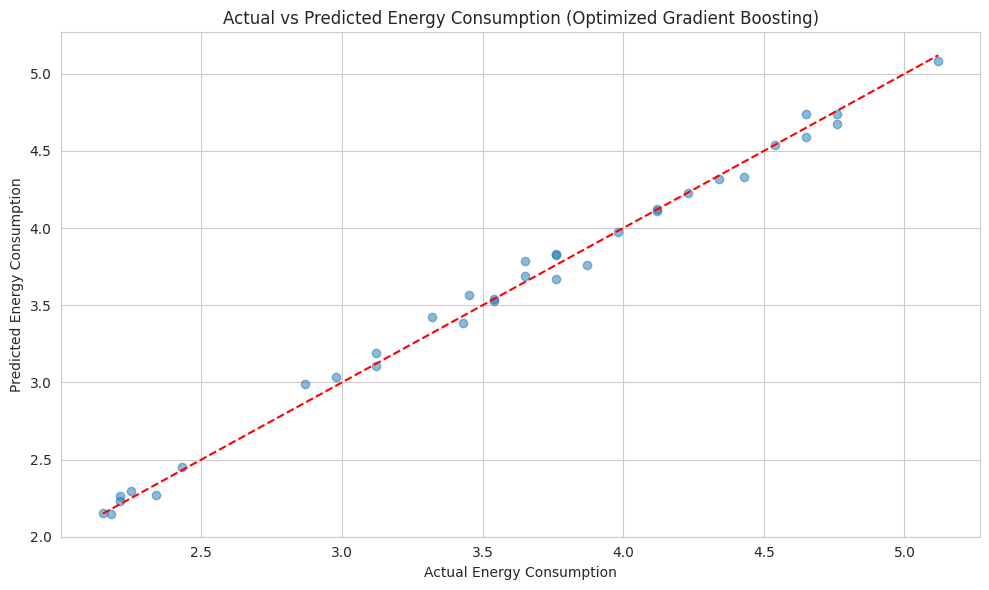

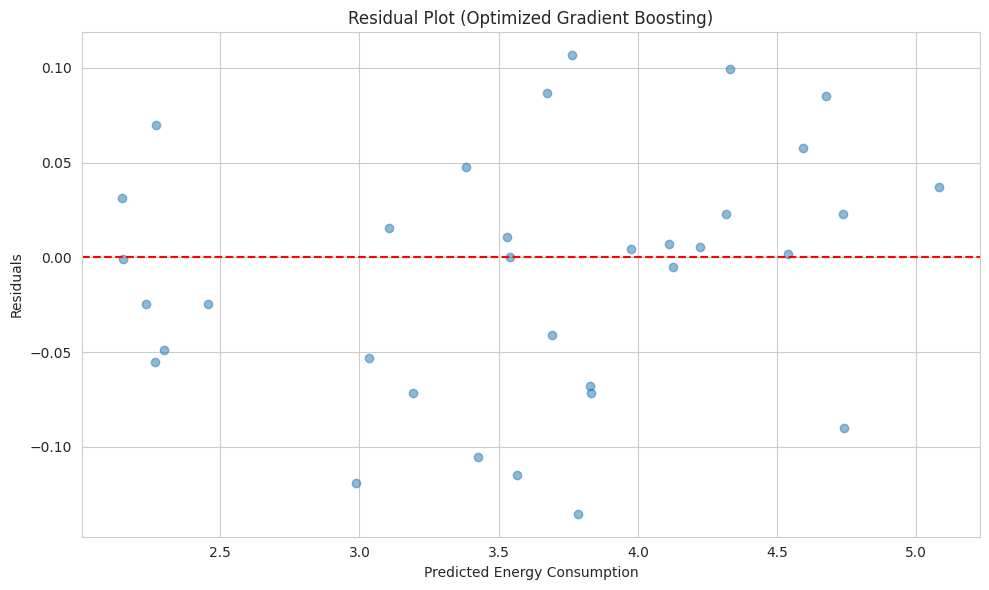

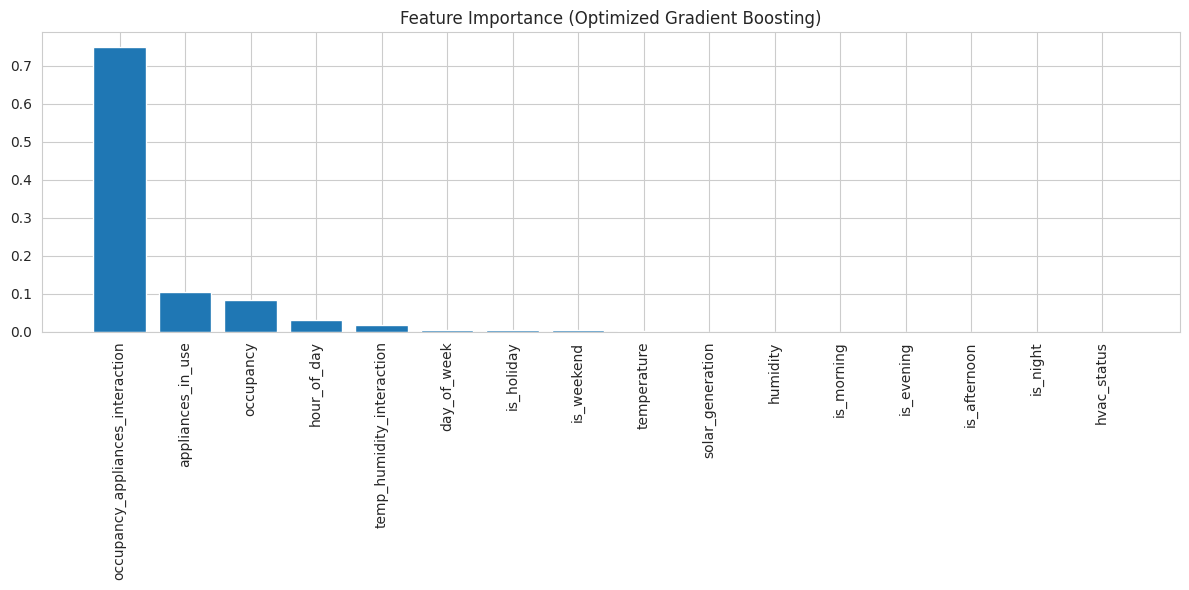

In [13]:
# Make predictions with the final model
final_model = optimized_model if 'optimized_model' in locals() else results[best_combined_idx]['model']
final_model_name = f"Optimized {best_combined_model_name}" if 'optimized_model' in locals() else best_combined_model_name

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.title(f'Actual vs Predicted Energy Consumption ({final_model_name})')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Energy Consumption')
plt.ylabel('Residuals')
plt.title(f'Residual Plot ({final_model_name})')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot feature importance for the final model
if hasattr(final_model, 'feature_importances_'):
    # For tree-based models
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f'Feature Importance ({final_model_name})')
    plt.bar(range(X_train.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
elif hasattr(final_model, 'coef_'):
    # For linear models
    coefficients = final_model.coef_
    importance = np.abs(coefficients)
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f'Feature Coefficients ({final_model_name})')
    plt.bar(range(X_train.shape[1]), coefficients[indices], align='center')
    plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

## Energy Consumption Tracking Visualization

Let's visualize the energy consumption during model training.

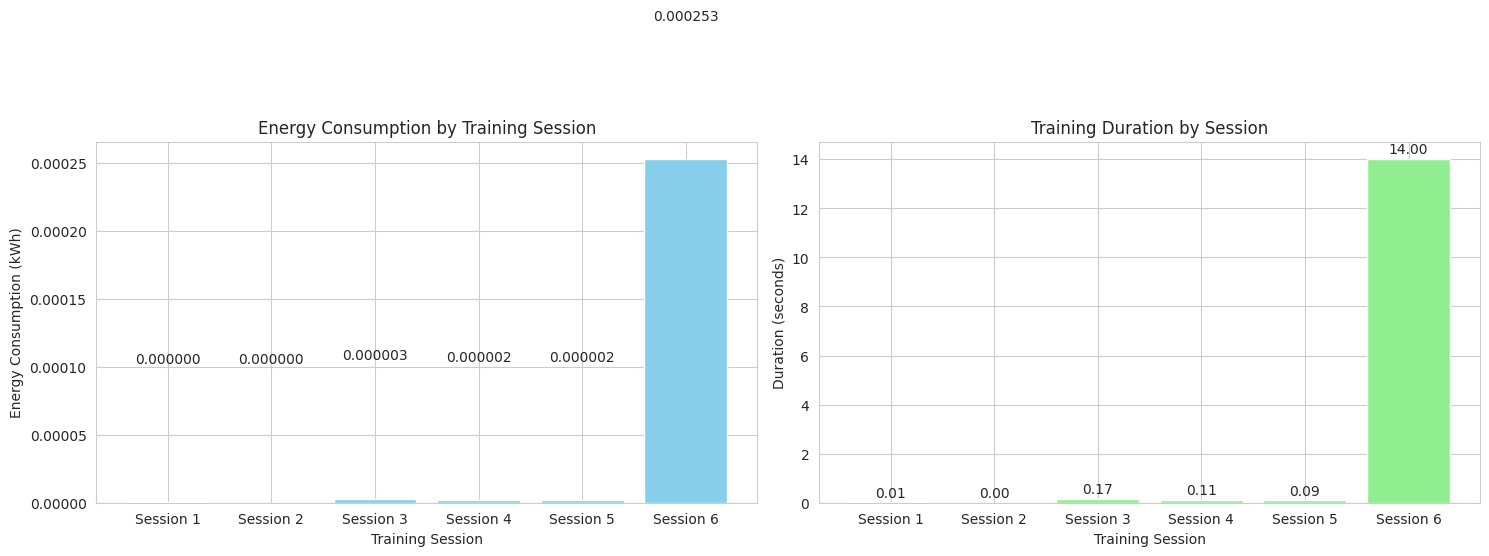

In [14]:
# Plot energy consumption history
energy_tracker.plot_energy_consumption()

## Conclusion and Sustainability Report

Let's summarize our findings and generate a sustainability report.

In [15]:
# Generate sustainability report
print("="*80)
print("                        SUSTAINABLE AI MODEL REPORT                        ")
print("="*80)
print(f"\nModel: {final_model_name}")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n" + "-"*80)
print("PERFORMANCE METRICS")
print("-"*80)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

print("\n" + "-"*80)
print("SUSTAINABILITY METRICS")
print("-"*80)

if 'optimized_model' in locals():
    print(f"Training Time: {energy_metrics['duration_seconds']:.4f} seconds")
    print(f"Energy Consumption: {energy_metrics['energy_consumption_kwh']:.6f} kWh")
    print(f"Carbon Footprint: {carbon_footprint:.6f} kg CO2eq")
    print(f"Model Size: {model_size_bytes / 1024:.2f} KB")
else:
    result = results[best_combined_idx]
    print(f"Training Time: {result['training_time']:.4f} seconds")
    print(f"Energy Consumption: {result['energy_consumption']:.6f} kWh")
    print(f"Carbon Footprint: {result['carbon_footprint']:.6f} kg CO2eq")
    print(f"Model Size: {result['model_size']:.2f} KB")

print("\n" + "-"*80)
print("ENVIRONMENTAL IMPACT EQUIVALENTS")
print("-"*80)

# Calculate equivalents
if 'optimized_model' in locals():
    carbon_kg = carbon_footprint
else:
    carbon_kg = results[best_combined_idx]['carbon_footprint']

# Car driving equivalent (120g CO2 per km)
car_km = carbon_kg / 0.12
print(f"Car Driving: {car_km:.2f} km")

# Smartphone charging equivalent (0.005 kWh per charge, ~1g CO2)
smartphone_charges = carbon_kg / 0.001
print(f"Smartphone Charges: {smartphone_charges:.2f} charges")

# LED light bulb equivalent (10W, 0.01 kWh per hour, ~2g CO2)
led_hours = carbon_kg / 0.002
print(f"LED Light Bulb: {led_hours:.2f} hours")

print("\n" + "-"*80)
print("SUSTAINABILITY RECOMMENDATIONS")
print("-"*80)
print("1. Consider using simpler models for tasks where high accuracy is not critical")
print("2. Implement early stopping to reduce unnecessary training iterations")
print("3. Use feature selection to reduce model complexity and improve efficiency")
print("4. Train models in regions with lower carbon intensity electricity")
print("5. Consider using renewable energy sources for model training and deployment")
print("6. Regularly monitor and optimize model performance and energy consumption")

print("\n" + "-"*80)
print("MODEL COMPARISON SUMMARY")
print("-"*80)
display(results_df[['Model', 'RMSE', 'R²', 'Energy (kWh)', 'Carbon (kg CO2)', 'Combined Score']].sort_values('Combined Score', ascending=False))

                        SUSTAINABLE AI MODEL REPORT                        

Model: Optimized Gradient Boosting
Date: 2025-05-20 20:01:08

--------------------------------------------------------------------------------
PERFORMANCE METRICS
--------------------------------------------------------------------------------
RMSE: 0.0644
MAE: 0.0512
R²: 0.9943

--------------------------------------------------------------------------------
SUSTAINABILITY METRICS
--------------------------------------------------------------------------------
Training Time: 14.0029 seconds
Energy Consumption: 0.000253 kWh
Carbon Footprint: 0.000096 kg CO2eq
Model Size: 0.05 KB

--------------------------------------------------------------------------------
ENVIRONMENTAL IMPACT EQUIVALENTS
--------------------------------------------------------------------------------
Car Driving: 0.00 km
Smartphone Charges: 0.10 charges
LED Light Bulb: 0.05 hours

-----------------------------------------------------------

,Model,RMSE,R²,Energy (kWh),Carbon (kg CO2),Combined Score
3,Gradient Boosting,0.071054,0.993080,2.075537e-06,7.887040e-07,99.449204
4,XGBoost,0.091517,0.988520,1.678167e-06,6.377034e-07,99.142585
2,Random Forest,0.104290,0.985091,3.092055e-06,1.174981e-06,98.858009
1,Ridge Regression,0.110790,0.983175,5.370643e-08,2.040844e-08,98.820235
0,Linear Regression,0.112846,0.982545,2.256307e-07,8.573968e-08,98.770594


## Save the Final Model

Let's save the final model for future use.

In [16]:
# Save the model and scaler
import pickle

# Save model
with open('sustainable_energy_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature list
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

print("Model and associated files saved successfully!")

# Download the files
from google.colab import files
files.download('sustainable_energy_model.pkl')
files.download('scaler.pkl')
files.download('features.pkl')

Model and associated files saved successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Example Prediction Function

Here's a function to make predictions with the saved model.

In [17]:
def predict_energy_consumption(input_data, model, scaler, feature_list):
    """
    Make energy consumption predictions using the trained model.

    Args:
        input_data: DataFrame with the required features
        model: Trained model
        scaler: Fitted scaler
        feature_list: List of features used by the model

    Returns:
        Predicted energy consumption
    """
    # Ensure input data has all required features
    for feature in feature_list:
        if feature not in input_data.columns:
            raise ValueError(f"Missing feature: {feature}")

    # Extract features in the correct order
    X = input_data[feature_list].values

    # Scale features
    X_scaled = scaler.transform(X)

    # Make prediction
    prediction = model.predict(X_scaled)

    return prediction

# Example usage
# Create sample input data
sample_input = X_test.iloc[:5].copy()

# Make predictions
sample_predictions = predict_energy_consumption(sample_input, final_model, scaler, features)

# Display results
print("Sample Predictions:")
for i, pred in enumerate(sample_predictions):
    actual = y_test.iloc[i]
    print(f"Sample {i+1}: Predicted = {pred:.4f} kWh, Actual = {actual:.4f} kWh, Error = {abs(pred - actual):.4f} kWh")

Sample Predictions:
Sample 1: Predicted = 5.0828 kWh, Actual = 5.1200 kWh, Error = 0.0372 kWh
Sample 2: Predicted = 2.9889 kWh, Actual = 2.8700 kWh, Error = 0.1189 kWh
Sample 3: Predicted = 3.4255 kWh, Actual = 3.3200 kWh, Error = 0.1055 kWh
Sample 4: Predicted = 2.1485 kWh, Actual = 2.1800 kWh, Error = 0.0315 kWh
Sample 5: Predicted = 3.7633 kWh, Actual = 3.8700 kWh, Error = 0.1067 kWh


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
